# Capstone MAIN

# Libraries

In [36]:
import wfdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, StratifiedGroupKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning) 
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', message = "Pandas requires version .* or newer of 'bottleneck'.*", category=UserWarning)

# setting random seed here for continiuty throughout code
random_seed = 42

# data processing

In [4]:


for file in os.listdir():
    if file.endswith(".dat"):
        record = wfdb.rdrecord(file[:-4], sampfrom=0, sampto=None)
        signals = record.p_signal
        raw_signals = record.d_signal
        signal_names = record.sig_name
        df = pd.DataFrame(data = signals, columns=record.sig_name)
        df['time'] = np.arange(len(df)) / record.fs
        # print(df.head())
        df.to_csv(file[:-4] + ".csv", index=False)



In [5]:
os.listdir()

['Subject9_SpO2HR.dat',
 'Subject11_SpO2HR.dat',
 'Subject12_SpO2HR.hea',
 'Subject19_SpO2HR_sync_merged.csv',
 'Subject17_SpO2HR_sync.csv',
 'Subject3_merged_fused.csv',
 'Subject13_SpO2HR_sync_merged.csv',
 'Subject19_merged_fused.csv',
 'Subject2_merged.csv',
 'Subject18_AccTempEDA.dat',
 'Subject17_SpO2HR_merged.csv',
 'Subject4_SpO2HR_sync.csv',
 'Subject10_AccTempEDA.dat',
 'Subject7_SpO2HR.csv',
 'Subject2_AccTempEDA.dat',
 'Subject12_merged_fused.csv',
 'Subject17_merged.csv',
 'Subject20_merged.csv',
 'Subject14_SpO2HR_sync_merged.csv',
 'Subject12_SpO2HR_merged.csv',
 'Subject7_SpO2HR.hea',
 'Subject4_SpO2HR.dat',
 'Subject8_merged_fused.csv',
 'Main.ipynb',
 'Subject18_SpO2HR_sync.csv',
 'Subject17_AccTempEDA.dat',
 'Subject12_SpO2HR.csv',
 'RECORDS',
 'Subject5_AccTempEDA.dat',
 'Subject16_AccTempEDA.dat',
 'Subject19_SpO2HR.dat',
 'Subject17_SpO2HR_sync_merged.csv',
 'Subject1_SpO2HR.dat',
 'Subject2_SpO2HR.hea',
 'Subject4_AccTempEDA.dat',
 'Subject12_merged.csv',
 'Subje

In [6]:
for file in os.listdir():
    if file.endswith('_SpO2HR.csv'):
        df = pd.read_csv(file)
        # print(df.head())
        df.drop(columns = ['time'], inplace=True)
        sync_df=pd.DataFrame(np.repeat(df.values, 8, axis=0), columns=df.columns)
        sync_df['time'] = np.arange(len(sync_df)) / 8
        sync_df.to_csv(file[:-4] + "_sync.csv", index=False)


In [7]:
for file in os.listdir():
    # for each subject, read in the sync file and the acc file

    for i in range(1,21):
        if file.startswith("Subject" + str(i)) and file.endswith("_sync.csv"):

            # read file in
            sync_df = pd.read_csv(file)

            # add other dataframe to sync df
            for other_file in os.listdir():
                if other_file.startswith("Subject" + str(i)) and other_file.endswith("AccTempEDA.csv"):
                    acc_df = pd.read_csv(other_file)

                    # merge dataframes
                    merged_df = pd.merge(sync_df, acc_df, how='inner', on='time')

                    # add physiological stress column
                    ## need the seconds for the physiological stress column -- each entry is 1/8 of a second, so need entries between 5 minutes and 10 minutes -- 5*60*8 for the start of the 5 minutes, then need 5 minutes after that so 10*60*8 is when the 5 minutes ends
                    merged_df['physiological_stress'] = np.where((merged_df['time'] >= 5*60*8) & (merged_df['time'] <= 10*60*8), 1, 0)
                    
                    # save merged dataframe
                    merged_df.to_csv("Subject" + str(i) + "_merged.csv", index=False)

# now we have all the merged dataframes, need to split them into training, validation, and testing sets -- each subject is named subjectX_merged.csv

In [9]:
os.listdir()

['Subject9_SpO2HR.dat',
 'Subject11_SpO2HR.dat',
 'Subject12_SpO2HR.hea',
 'Subject19_SpO2HR_sync_merged.csv',
 'Subject17_SpO2HR_sync.csv',
 'Subject3_merged_fused.csv',
 'Subject13_SpO2HR_sync_merged.csv',
 'Subject19_merged_fused.csv',
 'Subject2_merged.csv',
 'Subject18_AccTempEDA.dat',
 'Subject17_SpO2HR_merged.csv',
 'Subject4_SpO2HR_sync.csv',
 'Subject10_AccTempEDA.dat',
 'Subject7_SpO2HR.csv',
 'Subject2_AccTempEDA.dat',
 'Subject12_merged_fused.csv',
 'Subject17_merged.csv',
 'Subject20_merged.csv',
 'Subject14_SpO2HR_sync_merged.csv',
 'Subject12_SpO2HR_merged.csv',
 'Subject7_SpO2HR.hea',
 'Subject4_SpO2HR.dat',
 'Subject8_merged_fused.csv',
 'Main.ipynb',
 'Subject18_SpO2HR_sync.csv',
 'Subject17_AccTempEDA.dat',
 'Subject12_SpO2HR.csv',
 'RECORDS',
 'Subject5_AccTempEDA.dat',
 'Subject16_AccTempEDA.dat',
 'Subject19_SpO2HR.dat',
 'Subject17_SpO2HR_sync_merged.csv',
 'Subject1_SpO2HR.dat',
 'Subject2_SpO2HR.hea',
 'Subject4_AccTempEDA.dat',
 'Subject12_merged.csv',
 'Subje

# missing data

In [11]:
# checking for missing data in each file
for file in os.listdir():
    for i in range(1,21):
        if file.startswith("Subject" + str(i)+ "_merged.csv"):
            
            # reading in file
            df = pd.read_csv(file)

            # check data for missing values - should be no missing values throughout
            print(f'{file} has missing values: {df.isnull().values.any()}')
           
            # no missing values!

Subject2_merged.csv has missing values: False
Subject17_merged.csv has missing values: False
Subject20_merged.csv has missing values: False
Subject12_merged.csv has missing values: False
Subject7_merged.csv has missing values: False
Subject18_merged.csv has missing values: False
Subject15_merged.csv has missing values: False
Subject8_merged.csv has missing values: False
Subject10_merged.csv has missing values: False
Subject5_merged.csv has missing values: False
Subject13_merged.csv has missing values: False
Subject6_merged.csv has missing values: False
Subject3_merged.csv has missing values: False
Subject16_merged.csv has missing values: False
Subject9_merged.csv has missing values: False
Subject11_merged.csv has missing values: False
Subject4_merged.csv has missing values: False
Subject19_merged.csv has missing values: False
Subject1_merged.csv has missing values: False
Subject14_merged.csv has missing values: False


# outlier detection

In [12]:
# referencing https://www.sciencedirect.com/science/article/pii/S2307187724000452 here for background research on time series outlier detection -- also detecting outliers within each subject because data is subject specific 

# using isolation forest for outlier detection because of strengths listed in paper and common implementation in machine learning

from sklearn.ensemble import IsolationForest

def detect_outliers_isolation_forest(df, contamination=.05, random_state = 42):
    """"
    Detects outliers in a dataframe using Isolation Forest
    Returns a list of the indices of the outliers
    df: the dataframe to detect outliers in
    contamination: the proportion of outliers in the data
    random_state: the random state to use for reproducibility
    """""

    # selecting numeric features then converting to a list of features to use for outlier detection
    features = df.select_dtypes(include=[np.number]).columns.tolist()

    # removing the physiological stress column because it won't be helpful in detecting outliers in the other features -- this column is binary and will not contribute to the outlier detection process
    if 'physiological_stress' in features:
        features.remove('physiological_stress')
    
    # initializing the Isolation Forest model with the specified contamination, random state, and other parameters
    clf = IsolationForest(contamination=contamination, random_state=random_state, n_estimators=100, max_samples='auto')

    # fitting the model to the data using the selected features
    outlier_labels = clf.fit_predict(df[features])

    # The fit_predict method returns 1 for inliers and -1 for outliers - creating a mask to identify outliers for the function
    outlier_mask = outlier_labels == -1

    # returning the outlier mask which is a boolean array indicating which rows are outliers
    return outlier_mask

# utilizing outlier detection func†ion
for file in os.listdir():
    for i in range(1,21):
        if file.startswith("Subject" + str(i)+ "_merged.csv"):

            # reading in the merged dataframe for the subject
            df = pd.read_csv(file)

            # checking for outliers using the Isolation Forest method
            outlier_mask = detect_outliers_isolation_forest(df, contamination=.10, random_state=42)
            
            # printing out the number of outliers detected in the dataframe
            n_outliers = sum(outlier_mask)
            print(f'{file} has {sum(outlier_mask)} outliers')
           
            # important to note that the outliers are not removed from the data frame and this step is more so focused on detecting outliers

            # expecting to have more outliers in this data because of variability in nature of physiological data and the fact that the data is subject specific


Subject2_merged.csv has 1833 outliers
Subject17_merged.csv has 1825 outliers
Subject20_merged.csv has 2017 outliers
Subject12_merged.csv has 1823 outliers
Subject7_merged.csv has 1818 outliers
Subject18_merged.csv has 1826 outliers
Subject15_merged.csv has 1819 outliers
Subject8_merged.csv has 1826 outliers
Subject10_merged.csv has 1824 outliers
Subject5_merged.csv has 1825 outliers
Subject13_merged.csv has 1824 outliers
Subject6_merged.csv has 1824 outliers
Subject3_merged.csv has 1826 outliers
Subject16_merged.csv has 1823 outliers
Subject9_merged.csv has 1825 outliers
Subject11_merged.csv has 2026 outliers
Subject4_merged.csv has 1825 outliers
Subject19_merged.csv has 1822 outliers
Subject1_merged.csv has 1824 outliers
Subject14_merged.csv has 1823 outliers


# sensor fusion

In [14]:
# sensor fusion focused on combining data across sensors to provide better accuracy than from just one data source

# while the data is all from one sensor in my case - the data from the Empatica wristaband - the data is still from multiple sensors (SpO2HR, Acc, Temp, EDA) and can be combined to provide a more accurate model

# sensor fusion is a little bit like feature engineering that I have used in other machine learning projects


# initializing a function for sensor fusion -- using a function so I can easily apply it to each subject's merged dataframe and perform the same operations on each one while also demonstrating when there are specific issues in my implementation

def sensor_fusion(df):
    """
    Combines data from multiple sensors into a single feature
    Returns a dataframe with the sensor fusion features
    df: the dataframe to perform sensor fusion on
    """
    fused_df = df.copy()

    # creating an acceleration magnitude feature - degree of physical activity
    
    # checking if there are any acceleration columns in the dataframe, which there should be
    actual_acc_columns = []

    # checking for acceleration columns in the dataframe - looking for columns that contain 'ax', 'ay', or 'az' in their names given these are my specific acceleration axes and corresponding column names
    for col in df.columns:
        if any(acc_axis in col.lower() for acc_axis in ['ax', 'ay', 'az']):
            actual_acc_columns.append(col)

    # checking to see if there are all three axes for acceleration data - if there are not all three axes, we cannot compute the magnitude
    if len(actual_acc_columns) >= 3:

        # sorting the actual acceleration columns to ensure they are in a consistent order for calculating the magnitude
        actual_acc_columns = sorted(actual_acc_columns)

        # calculating the magnitude of acceleration using the formula sqrt(ax^2 + ay^2 + az^2) - this is a common way to calculate the magnitude of a 3D vector
        fused_df['acc_magnitude'] = np.sqrt(df[actual_acc_columns[0]]**2 + df[actual_acc_columns[1]]**2 + df[actual_acc_columns[2]]**2)

    # creating activity adjusted heart rate feature because heart rate generally increases with increased physical activity, as measured by acceleration magnitude

    # checking if 'hr' column exists in the dataframe and if 'acc_magnitude' has been created
    if 'hr' in df.columns and 'acc_magnitude' in fused_df.columns:

        # adjusting heart rate by dividing it by (1 + acceleration magnitude) - this is a simple way to adjust heart rate based on physical activity
        fused_df['hr_activity_adjusted'] = fused_df['hr'] / (1 + fused_df['acc_magnitude'])
    
    # creating temperature to EDA ratio feature because body temperature generally increases with physical activity, and increased body temperature can be manifested physically through sweat which is measured by electro-dermal activity -- finding a ratio of body temperature to EDA can provide a measure of how much someone is sweating relative to their body temperature

    if 'temp' in df.columns and 'EDA' in df.columns:

        # creating a new feature that is the ratio of temperature to EDA - adding a small constant to EDA to avoid division by zero
        fused_df['temp_eda_ratio'] = fused_df['temp'] / (fused_df['EDA'] + .001)

    # returning the fused dataframe with the new features
    return fused_df

# iterating through each subject and applying the sensor fusion function to each subject's merged dataframe, then returning the fused dataframe to a new CSV file
for file in os.listdir():
    for i in range(1,21):
        if file.startswith("Subject" + str(i)+ "_merged.csv"):
            df = pd.read_csv(file)
            fused_df = sensor_fusion(df)
            fused_df.to_csv("Subject" + str(i) + "_merged_fused.csv", index=False)

# further feature engineering 

In [16]:
# initially decided to return to this after running my models to see if it would be necessary 

# given strength of models on initial features and sensor fused features, I do not think further feature engineering is necessary

# discretization

In [17]:
# will return back to this step to see if it is necessary to use discretization in the final model - discretization is the process of converting continuous data into discrete data, which can be useful for some models

# after running the models, I found that the models performed well without discretization - but this is something I can always return to in the future if needed

# feature selection

In [18]:
# using all features for now, will consider removing if some features are not useful and detract from in the final model as based on feature importance

# Given strength of models with all features, I do not think further feature engineering is necessary at this time

# feature extraction

In [19]:
# not necessary here because all data is numeric -- ie: data isn't image or text based so there aren't features to extract

# train test splitting

In [85]:
# initially was using leave one subject out (LOSO) cross validation out because of individual data frames for each subject -- each subject is a different person and the data is subject specific, but given the computational requirements for LOSO and my computational restrictions for this project, I decided to switch to stratified K-fold cross-validation with instead

# stratified K-fold cross-validation is a method that ensures each fold has a representative sample of the data from each subject, which is important for generalizing the model to new subjects


# setting up the data for modeling - reading in all the fused dataframes and combining them into a single dataframe for modeling

# creating an empty list to store all the dataframes for each subject
all_subjects = []

# creating empty list to store subject_ids from each data frame
subject_ids = []

# iterating through each file in the current directory
for file in os.listdir():
    for i in range(1,21):
        if file.startswith(f"Subject{i}_merged_fused.csv"):
            df = pd.read_csv(file)

            # adding column for subject_id to keep track of which subject the data came from
            df['subject_id'] = i

            # appending the dataframe to the list of all subjects
            all_subjects.append(df)
            break

# checking if all_subjects list is not empty before concatenating
if all_subjects:

    # concatenating all the dataframes in the list into a single dataframe
    all_subjects_df = pd.concat(all_subjects, ignore_index=True)

# checking to see if the code worked correctly
    print(f"sucessfully combined {len(all_subjects)} dataframes into one")


sucessfully combined 20 dataframes into one


In [86]:
# investigating the shape of the all_subjects_df to ensure combining went correctly
all_subjects_df.shape

(368748, 13)

# hyperparameter tuning

In [140]:
def evaluate_model(X_train, y_train, X_test, y_test, model_name, model, use_smote=True, random_seed=42):
    """
    Train and evaluate a single model
    
    Parameters:
    -----------
    X_train, y_train : Training data
    X_test, y_test : Test data
    model_name : Name of the model for reporting
    model : The model object to train
    use_smote : Whether to apply SMOTE
    random_seed : Random seed for reproducibility
    
    Returns:
    --------
    dict : Performance metrics and trained model
    """
    # Scale features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply SMOTE
    if use_smote:
        try:
            # Count samples in each class
            unique_classes, class_counts = np.unique(y_train, return_counts=True)
            min_samples = np.min(class_counts)
            
            # Only apply SMOTE if enough samples -- had issues here
            if min_samples > 5:
                smote = SMOTE(
                    random_state=random_seed, 
                    k_neighbors=min(5, min_samples-1)
                )
                X_train_final, y_train_final = smote.fit_resample(X_train_scaled, y_train)
                print(f"  After SMOTE - X_train: {X_train_final.shape}, y_train: {y_train_final.shape}")
            else:
                X_train_final, y_train_final = X_train_scaled, y_train
        except Exception as e:
            print(f"  Error in SMOTE: {e}. Using original data.")
            X_train_final, y_train_final = X_train_scaled, y_train
    else:
        X_train_final, y_train_final = X_train_scaled, y_train
    
    # Train given model on smote data
    try:
        model.fit(X_train_final, y_train_final)
        
        # Predict and evaluate
        y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        accuracy = balanced_accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred, output_dict=True)
        
        print(f"  {model_name} - Balanced accuracy: {accuracy:.4f}")
        
        # Return results
        return {
            'model_name': model_name,
            'accuracy': accuracy,
            'confusion_matrix': cm,
            'classification_report': cr,
            'model': model
        }
    except Exception as e:
        print(f"  Error training {model_name}: {e}")
        return None

In [132]:

def plot_comparative_results(all_results, summary):
    """Plot comparative results of different models"""
    # Boxplot of accuracy by model type
    plt.figure(figsize=(10, 6))
    
    model_data = []
    model_names = []
    
    for model_name, results in all_results.items():
        if results:
            accuracies = [r['accuracy'] for r in results]
            model_data.append(accuracies)
            model_names.append(model_name)
    
    if model_data:
        plt.boxplot(model_data, labels=model_names)
        plt.ylabel('Balanced Accuracy')
        plt.title('Model Performance Comparison')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    # Plot confusion matrices for the best model of each
    best_models_cm = {}
    
    for model_name, results in all_results.items():
        if results:
            # Find the best model based on accuracy
            best_idx = np.argmax([r['accuracy'] for r in results])
            best_result = results[best_idx]
            
            # Store the confusion matrix
            best_models_cm[model_name] = {
                'cm': best_result['confusion_matrix'],
                'accuracy': best_result['accuracy']
            }
    
    # Plot confusion matrices in a grid
    if best_models_cm:
        num_models = len(best_models_cm)
        cols = min(3, num_models)
        rows = (num_models + cols - 1) // cols
        
        plt.figure(figsize=(5*cols, 4*rows))
        
        for i, (model_name, data) in enumerate(best_models_cm.items()):
            plt.subplot(rows, cols, i+1)
            cm = data['cm']
            
            # Normalize confusion matrix
            cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            cm_norm = np.nan_to_num(cm_norm)  # Replace NaN with 0
            
            sns.heatmap(cm_norm, annot=cm, fmt='d', cmap='Blues', 
                        cbar=False, annot_kws={"size": 10})
            
            plt.title(f"{model_name}\nAcc: {data['accuracy']:.4f}")
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
        
        plt.tight_layout()
        plt.show()

# adapted from GWU DATS 6202 Machine Learning

def run_comparative_analysis(X, y, random_seed=42, use_smote=True, tune_hyperparams=True):
    """
    Run comparative analysis of multiple models
    
    Parameters:
    -----------
    X : Features
    y : Target
    random_seed : Random seed for reproducibility
    use_smote : Whether to apply SMOTE function
    tune_hyperparams : Whether to tune hyperparameters
    
    Returns:
    --------
    dict : Results for all models and folds
    """
    # Convert to numpy arrays
    if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
        X_data = X.values
        feature_names = X.columns
    else:
        X_data = np.array(X)
        feature_names = [f"Feature_{i}" for i in range(X_data.shape[1])]
        
    if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
        y_data = y.values
    else:
        y_data = np.array(y)
    
    # Ensure same number of samples
    if len(X_data) != len(y_data):
        min_len = min(len(X_data), len(y_data))
        X_data = X_data[:min_len]
        y_data = y_data[:min_len]
        print(f"Trimmed arrays to match: {min_len} samples")
    
    # Define models
    models = {
        'XGBoost': XGBClassifier(
            use_label_encoder=False, # suppress warning about label encoder
            eval_metric='logloss', # using logloss for binary classification
            random_state=random_seed, # for continuity 
            verbosity=0 # don't print out too much info during training
        ),
        'Logistic Regression': LogisticRegression(
            max_iter=1000, # maximum number of iterations for convergence
            random_state=random_seed # for continuity
        ),
        'MLP Classifier': MLPClassifier(
            max_iter=1000, # maximum number of iterations for convergence
            random_state=random_seed  # for continuity
        ),
        'Random Forest': RandomForestClassifier(
            random_state=random_seed # for continuity
        ),
        'Hist Gradient Boosting': HistGradientBoostingClassifier(
            random_state=random_seed # for continuity
        )
    }
    
    # Define parameter grids for tuning
    param_grids = {
        'XGBoost': {
            'max_depth': [3, 5, 7], # maximum depth of each tree in forest
            'n_estimators': [100, 300, 500], # number of boosting rounds
            'learning_rate': [0.01, 0.1, 0.3], # learning rate for boosting
            'subsample': [0.8, 1.0], # fraction of samples to use for each tree, within training
            'colsample_bytree': [0.8, 1.0], # fraction of features to use for each tree
            'min_child_weight': [1, 3, 5] # minimum sum of sample weight (hessian) needed to create a new node (child) in a tree
        },
        'Logistic Regression': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100], # Inverse of regularization strength; smaller values specify stronger regularization
            'penalty': ['l2', None], # Regularization type; 'l2' is standard, None means no regularization
            'tol': [1e-5, 1e-4, 1e-3] # Tolerance for stopping criteria; smaller values mean more precise convergence
        },
        'MLP Classifier': {
            'alpha': [0.0001, 0.001, 0.01], # L2 penalty (regularization term) parameter to prevent overfitting by constraiing weights
            'learning_rate_init': [0.001, 0.01],  # Initial learning rate used in the optimizer, learning rate determines how much parameters are adjusted
            'hidden_layer_sizes': [(50,), (100,), (50, 50)] # Number of neurons in the hidden layers - usually between input and output size
        },
        'Random Forest': {
            'n_estimators': [100, 200, 300], # Number of trees in the forest
            'max_depth': [None, 10, 20, 30], # Maximum depth of the tree. If None, nodes are expanded until all leaves are pure or contain less than min_samples_split samples
            'min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
            'min_samples_leaf': [1, 2, 4] # Minimum number of samples required to be at a leaf node
        },
        'Hist Gradient Boosting': {
            'max_depth': [None, 3, 5], # Maximum depth of the individual trees
            'learning_rate': [0.01, 0.1, 0.3], # Learning rate shrinks the contribution of each tree in HGBC
            'max_iter': [100, 200] # Number of boosting iterations (trees to fit)
        }
    }
    
    # Create stratified splits with 5 splits for best final model performance
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    all_results = {model_name: [] for model_name in models.keys()}
    
    # For storing the best model of each type
    best_models = {}
    
    # Process each fold
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_data, y_data)):
        print(f"\nProcessing Fold {fold+1}/5")
        
        # Get train/test data
        X_train, X_test = X_data[train_idx], X_data[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]
        
        print(f"Train shapes: X_train {X_train.shape}, y_train {y_train.shape}")
        print(f"Test shapes: X_test {X_test.shape}, y_test {y_test.shape}")
        
        # Process each model
        for model_name, model in models.items():
            print(f"\nTraining {model_name}...")
            
            # Apply hyperparameter tuning if requested
            if tune_hyperparams:
                print(f"  Tuning hyperparameters for {model_name}...")
                
                # Create inner CV for tuning with 3 splits
                inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed)
                
                # Scale features for tuning
                scaler = MinMaxScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                
                # Apply SMOTE for tuning if enabled
                if use_smote:
                    try:
                        unique_classes, class_counts = np.unique(y_train, return_counts=True)
                        min_samples = np.min(class_counts)
                        
                        if min_samples > 5:
                            smote = SMOTE(
                                random_state=random_seed, 
                                k_neighbors=min(5, min_samples-1)
                            )
                            X_train_scaled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
                        else:
                            y_train_resampled = y_train

                    # raise error if issue using SMOTE
                    except Exception as e:
                        print(f"  Error in SMOTE for tuning: {e}. Using original data.")
                        y_train_resampled = y_train
                else:
                    y_train_resampled = y_train
                
                # Create and run randomized search
                try:
                    search = RandomizedSearchCV(
                        model, # the model to tune
                        param_distributions=param_grids[model_name], # using the parameter grid defined above
                        n_iter=10, # number of parameter settings to sample
                        scoring='balanced_accuracy', # using balanced accuracy for evaluation
                        cv=inner_cv, # inner cross-validation for tuning
                        random_state=random_seed, # for continuity
                        n_jobs=-1, # use all available cores
                        verbose=0 # less output during tuning
                    )
                    
                    # Fit the given model's hyperparameter search
                    search.fit(X_train_scaled, y_train_resampled)

                    # pull best parameters and best estimator for the given model
                    best_params = search.best_params_
                    tuned_model = search.best_estimator_
                    
                    print(f"  Best parameters: {best_params}")
                    
                    # Evaluate the tuned model using evaluate_model function which also produces cm and classification report
                    result = evaluate_model(
                        X_train, y_train, X_test, y_test,
                        model_name, tuned_model,
                        use_smote=use_smote,
                        random_seed=random_seed
                    )
                    
                    if result:
                        result['fold'] = fold + 1
                        result['best_params'] = best_params
                        all_results[model_name].append(result)

                # trying to handle errors here 
                except Exception as e:
                    print(f"  Error in hyperparameter tuning for {model_name}: {e}")
                    
                    # Fall back to default model without tuned parameters 
                    result = evaluate_model(
                        X_train, y_train, X_test, y_test,
                        model_name, model,
                        use_smote=use_smote,
                        random_seed=random_seed
                    )
                    
                    if result:
                        result['fold'] = fold + 1
                        result['best_params'] = "Tuning failed, using default parameters"
                        all_results[model_name].append(result)
            else:
                # again if tuning fails, fall back option for default parameters
                # Evaluate with default parameters
                result = evaluate_model(
                    X_train, y_train, X_test, y_test,
                    model_name, model,
                    use_smote=use_smote,
                    random_seed=random_seed
                )
                
                if result:
                    result['fold'] = fold + 1
                    result['best_params'] = "Default parameters used"
                    all_results[model_name].append(result)
    
    # Calculate average performance for each model
    print("\n--- Summary of Results ---")
    summary = {}
    
    for model_name, results in all_results.items():
        if results:
            accuracies = [r['accuracy'] for r in results]
            mean_accuracy = np.mean(accuracies) # for each model's accuracy across folds
            std_accuracy = np.std(accuracies) # standard deviation of accuracies across folds
            
            print(f"{model_name}: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
            
            # Save best model of each type
            best_idx = np.argmax(accuracies)
            best_models[model_name] = results[best_idx]['model']
            
            # Save summary stats
            summary[model_name] = {
                'mean_accuracy': mean_accuracy,
                'std_accuracy': std_accuracy,
                'individual_accuracies': accuracies
            }
        else:
            # error handling
            print(f"{model_name}: Failed to train")
    
    # Plot comparative results if at least one successful model
    if any(all_results.values()):
        plot_comparative_results(all_results, summary)
    
    return {
        'all_results': all_results,
        'summary': summary,
        'best_models': best_models,
        'feature_names': feature_names
    }

def save_best_model(results):
    """
    Save the best model from all models tested
    
    Parameters:
    -----------
    results : Results from run_comparative_analysis
    """    
    summary = results['summary']
    best_models = results['best_models']
    
    # Find the best model overall
    best_model_name = max(summary, key=lambda x: summary[x]['mean_accuracy'])
    best_model = best_models[best_model_name]
    
    # Save best model
    
    print(f"Best model ({best_model_name})")
    print(f"Mean accuracy: {summary[best_model_name]['mean_accuracy']:.4f}")
    
    return best_model_name, best_model

In [ ]:
def plot_feature_importance(results, top_n=10):
    """
    Plot feature importance for models that support it
    
    Parameters:
    -----------
    results : Results from run_comparative_analysis
    top_n : Number of top features to show
    """
    feature_names = results['feature_names']
    best_models = results['best_models']
    
    importance_data = {}
    
    # Extract feature importance from models that support it -- XGBoost, Random Forest, Hist Gradient Boosting, and Logistic Regression
    for model_name, model in best_models.items():
        if model_name == 'XGBoost':
            importance = model.feature_importances_
            importance_data[model_name] = {
                'importance': importance, # get feature importances from the model
                'type': 'direct' # direct importance from the model -- generalized for cross model comparison
            }
        elif model_name == 'Random Forest':
            importance = model.feature_importances_
            importance_data[model_name] = {
                'importance': importance, 
                'type': 'direct'
            }
        elif model_name == 'Hist Gradient Boosting':
            if hasattr(model, 'feature_importances_'):
                importance = model.feature_importances_
                importance_data[model_name] = {
                    'importance': importance,
                    'type': 'direct'
                }
        elif model_name == 'Logistic Regression':
            if hasattr(model, 'coef_'):
                importance = np.abs(model.coef_)[0]
                importance_data[model_name] = {
                    'importance': importance,
                    'type': 'coefficient' # using absolute value of coefficients as importance instead of direct because not applicable w LR
                }
    
    # Plot feature importance for each model
    for model_name, data in importance_data.items():
        importance = data['importance']
        
        # Sort features by importance
        indices = np.argsort(importance)[::-1]
        
        # Plot top_n features
        plt.figure(figsize=(10, 6))
        
        # Limit to top_n features or all features if less than top_n
        n_features = min(top_n, len(feature_names))
        
        plt.barh(range(n_features), importance[indices[:n_features]])
        plt.yticks(range(n_features), [feature_names[i] for i in indices[:n_features]])
        plt.xlabel('Feature Importance')
        plt.title(f'Top {n_features} Features for {model_name}')
        plt.tight_layout()
        plt.show()
    
    return importance_data

# Model Selection


Processing Fold 1/5
Train shapes: X_train (294998, 10), y_train (294998,)
Test shapes: X_test (73750, 10), y_test (73750,)

Training XGBoost...
  Tuning hyperparameters for XGBoost...


/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:6

  Best parameters: {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
  Applying SMOTE (min class samples: 1618)
  After SMOTE - X_train: (586760, 10), y_train: (586760,)
  XGBoost - Balanced accuracy: 0.9912

Training Logistic Regression...
  Tuning hyperparameters for Logistic Regression...


/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/s

  Best parameters: {'tol': 1e-05, 'penalty': None, 'C': 1}
  Applying SMOTE (min class samples: 1618)
  After SMOTE - X_train: (586760, 10), y_train: (586760,)
  Logistic Regression - Balanced accuracy: 0.9023

Training MLP Classifier...
  Tuning hyperparameters for MLP Classifier...
  Best parameters: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (50, 50), 'alpha': 0.001}
  Applying SMOTE (min class samples: 1618)
  After SMOTE - X_train: (586760, 10), y_train: (586760,)
  MLP Classifier - Balanced accuracy: 0.9987

Training Random Forest...
  Tuning hyperparameters for Random Forest...


/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:6

  Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
  Applying SMOTE (min class samples: 1618)
  After SMOTE - X_train: (586760, 10), y_train: (586760,)
  Random Forest - Balanced accuracy: 0.9863

Training Hist Gradient Boosting...
  Tuning hyperparameters for Hist Gradient Boosting...


/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:6

  Best parameters: {'max_iter': 200, 'max_depth': 3, 'learning_rate': 0.3}
  Applying SMOTE (min class samples: 1618)
  After SMOTE - X_train: (586760, 10), y_train: (586760,)
  Hist Gradient Boosting - Balanced accuracy: 0.9924

Processing Fold 2/5
Train shapes: X_train (294998, 10), y_train (294998,)
Test shapes: X_test (73750, 10), y_test (73750,)

Training XGBoost...
  Tuning hyperparameters for XGBoost...
  Best parameters: {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
  Applying SMOTE (min class samples: 1617)
  After SMOTE - X_train: (586762, 10), y_train: (586762,)
  XGBoost - Balanced accuracy: 0.9900

Training Logistic Regression...
  Tuning hyperparameters for Logistic Regression...


/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/s

  Best parameters: {'tol': 0.0001, 'penalty': None, 'C': 0.1}
  Applying SMOTE (min class samples: 1617)
  After SMOTE - X_train: (586762, 10), y_train: (586762,)
  Logistic Regression - Balanced accuracy: 0.9032

Training MLP Classifier...
  Tuning hyperparameters for MLP Classifier...
  Best parameters: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (50, 50), 'alpha': 0.0001}
  Applying SMOTE (min class samples: 1617)
  After SMOTE - X_train: (586762, 10), y_train: (586762,)
  MLP Classifier - Balanced accuracy: 0.9985

Training Random Forest...
  Tuning hyperparameters for Random Forest...


/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:6

  Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}
  Applying SMOTE (min class samples: 1617)
  After SMOTE - X_train: (586762, 10), y_train: (586762,)
  Random Forest - Balanced accuracy: 0.9851

Training Hist Gradient Boosting...
  Tuning hyperparameters for Hist Gradient Boosting...


/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


  Best parameters: {'max_iter': 100, 'max_depth': 5, 'learning_rate': 0.3}
  Applying SMOTE (min class samples: 1617)
  After SMOTE - X_train: (586762, 10), y_train: (586762,)
  Hist Gradient Boosting - Balanced accuracy: 0.9901

Processing Fold 3/5
Train shapes: X_train (294998, 10), y_train (294998,)
Test shapes: X_test (73750, 10), y_test (73750,)

Training XGBoost...
  Tuning hyperparameters for XGBoost...
  Best parameters: {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
  Applying SMOTE (min class samples: 1617)
  After SMOTE - X_train: (586762, 10), y_train: (586762,)
  XGBoost - Balanced accuracy: 0.9888

Training Logistic Regression...
  Tuning hyperparameters for Logistic Regression...


/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/s

  Best parameters: {'tol': 1e-05, 'penalty': None, 'C': 1}
  Applying SMOTE (min class samples: 1617)
  After SMOTE - X_train: (586762, 10), y_train: (586762,)
  Logistic Regression - Balanced accuracy: 0.9019

Training MLP Classifier...
  Tuning hyperparameters for MLP Classifier...
  Best parameters: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (50,), 'alpha': 0.0001}
  Applying SMOTE (min class samples: 1617)
  After SMOTE - X_train: (586762, 10), y_train: (586762,)
  MLP Classifier - Balanced accuracy: 0.9973

Training Random Forest...
  Tuning hyperparameters for Random Forest...
  Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}
  Applying SMOTE (min class samples: 1617)
  After SMOTE - X_train: (586762, 10), y_train: (586762,)
  Random Forest - Balanced accuracy: 0.9863

Training Hist Gradient Boosting...
  Tuning hyperparameters for Hist Gradient Boosting...


/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


  Best parameters: {'max_iter': 200, 'max_depth': 5, 'learning_rate': 0.1}
  Applying SMOTE (min class samples: 1617)
  After SMOTE - X_train: (586762, 10), y_train: (586762,)
  Hist Gradient Boosting - Balanced accuracy: 0.9887

Processing Fold 4/5
Train shapes: X_train (294999, 10), y_train (294999,)
Test shapes: X_test (73749, 10), y_test (73749,)

Training XGBoost...
  Tuning hyperparameters for XGBoost...
  Best parameters: {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
  Applying SMOTE (min class samples: 1618)
  After SMOTE - X_train: (586762, 10), y_train: (586762,)
  XGBoost - Balanced accuracy: 0.9949

Training Logistic Regression...
  Tuning hyperparameters for Logistic Regression...


/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/s

  Best parameters: {'tol': 1e-05, 'penalty': None, 'C': 1}
  Applying SMOTE (min class samples: 1618)
  After SMOTE - X_train: (586762, 10), y_train: (586762,)
  Logistic Regression - Balanced accuracy: 0.9046

Training MLP Classifier...
  Tuning hyperparameters for MLP Classifier...
  Best parameters: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (50,), 'alpha': 0.0001}
  Applying SMOTE (min class samples: 1618)
  After SMOTE - X_train: (586762, 10), y_train: (586762,)
  MLP Classifier - Balanced accuracy: 0.9982

Training Random Forest...
  Tuning hyperparameters for Random Forest...
  Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
  Applying SMOTE (min class samples: 1618)
  After SMOTE - X_train: (586762, 10), y_train: (586762,)
  Random Forest - Balanced accuracy: 0.9974

Training Hist Gradient Boosting...
  Tuning hyperparameters for Hist Gradient Boosting...


/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


  Best parameters: {'max_iter': 100, 'max_depth': 5, 'learning_rate': 0.3}
  Applying SMOTE (min class samples: 1618)
  After SMOTE - X_train: (586762, 10), y_train: (586762,)
  Hist Gradient Boosting - Balanced accuracy: 0.9986

Processing Fold 5/5
Train shapes: X_train (294999, 10), y_train (294999,)
Test shapes: X_test (73749, 10), y_test (73749,)

Training XGBoost...
  Tuning hyperparameters for XGBoost...
  Best parameters: {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
  Applying SMOTE (min class samples: 1618)
  After SMOTE - X_train: (586762, 10), y_train: (586762,)
  XGBoost - Balanced accuracy: 0.9912

Training Logistic Regression...
  Tuning hyperparameters for Logistic Regression...


/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/evaschwartz/anaconda3/lib/python3.11/s

  Best parameters: {'tol': 1e-05, 'penalty': None, 'C': 1}
  Applying SMOTE (min class samples: 1618)
  After SMOTE - X_train: (586762, 10), y_train: (586762,)
  Logistic Regression - Balanced accuracy: 0.9072

Training MLP Classifier...
  Tuning hyperparameters for MLP Classifier...
  Best parameters: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (50,), 'alpha': 0.0001}
  Applying SMOTE (min class samples: 1618)
  After SMOTE - X_train: (586762, 10), y_train: (586762,)
  MLP Classifier - Balanced accuracy: 0.9985

Training Random Forest...
  Tuning hyperparameters for Random Forest...


/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:6

  Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}
  Applying SMOTE (min class samples: 1618)
  After SMOTE - X_train: (586762, 10), y_train: (586762,)
  Random Forest - Balanced accuracy: 0.9863

Training Hist Gradient Boosting...
  Tuning hyperparameters for Hist Gradient Boosting...


/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/evaschwartz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


  Best parameters: {'max_iter': 100, 'max_depth': 5, 'learning_rate': 0.3}
  Applying SMOTE (min class samples: 1618)
  After SMOTE - X_train: (586762, 10), y_train: (586762,)
  Hist Gradient Boosting - Balanced accuracy: 0.9913

--- Summary of Results ---
XGBoost: 0.9912 ± 0.0021
Logistic Regression: 0.9038 ± 0.0019
MLP Classifier: 0.9983 ± 0.0005
Random Forest: 0.9883 ± 0.0046
Hist Gradient Boosting: 0.9922 ± 0.0034


/var/folders/by/7wtblks16yq6mq5dr7bbc4t00000gn/T/ipykernel_48366/2713001725.py:334: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(model_data, labels=model_names)


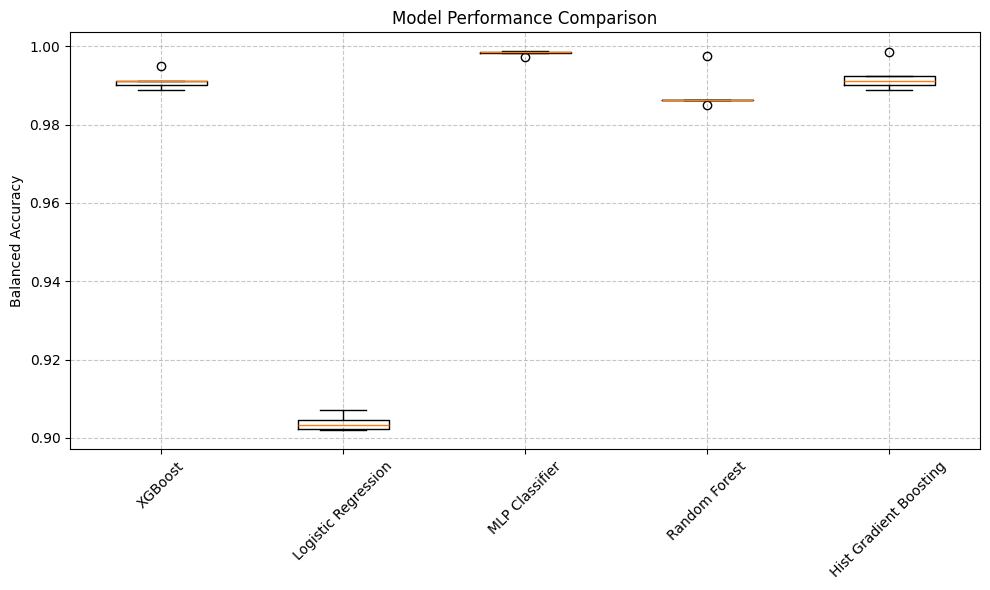

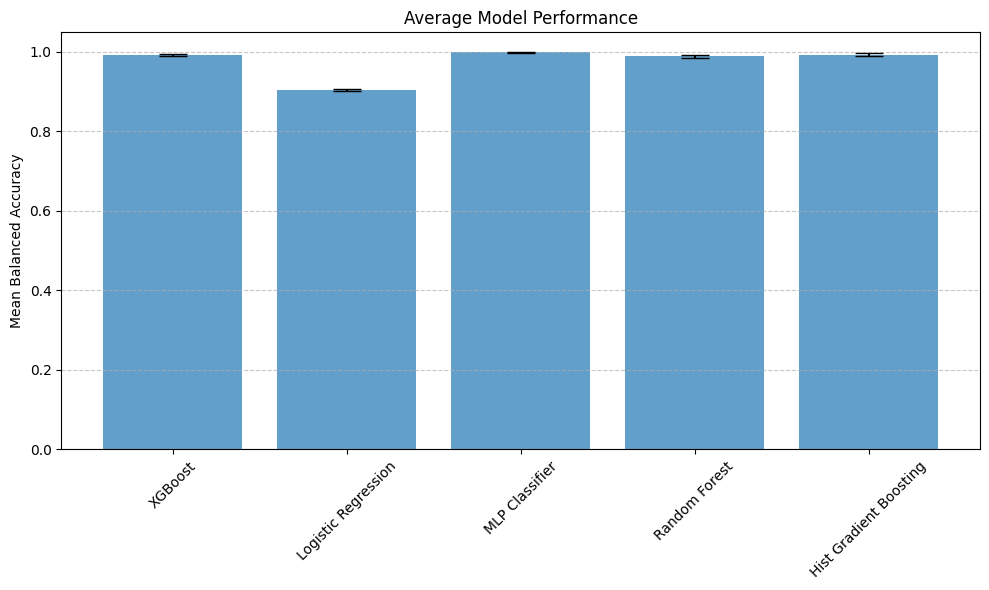

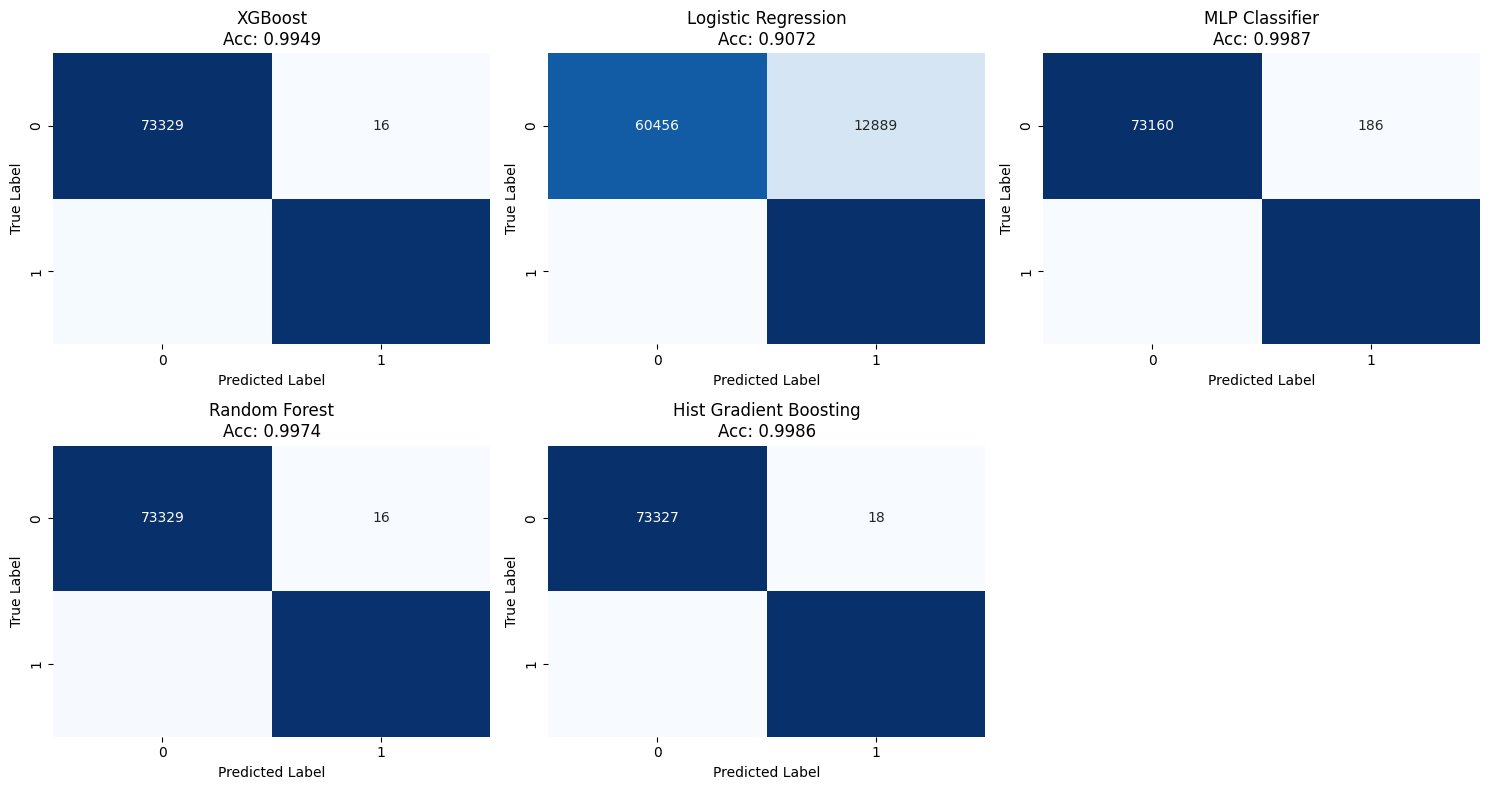

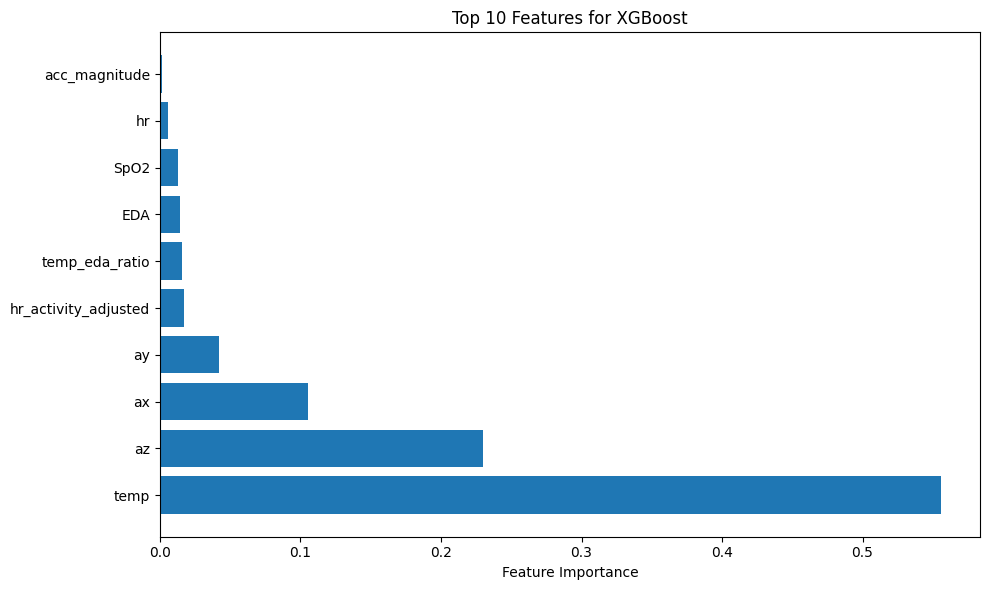

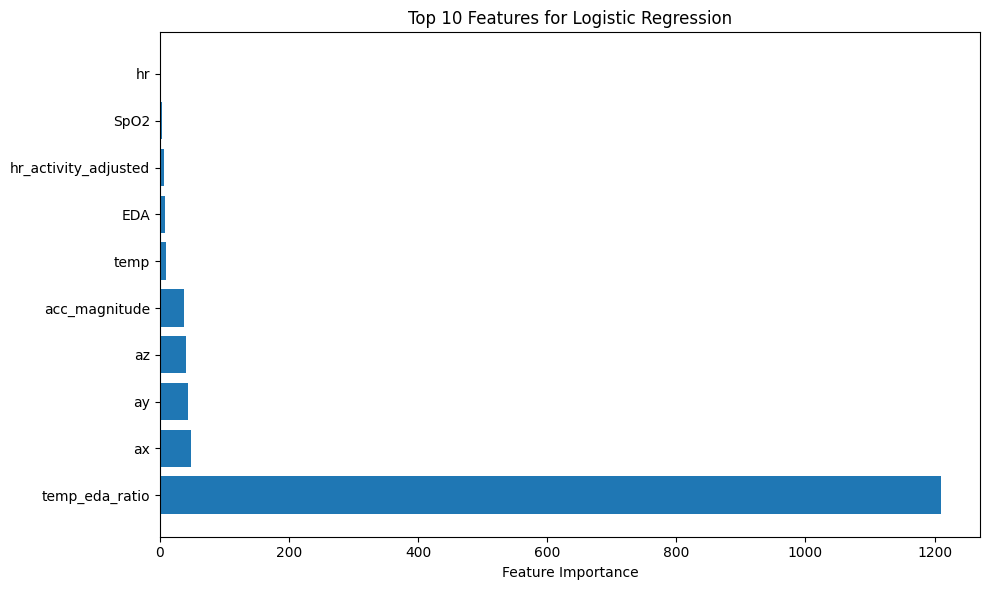

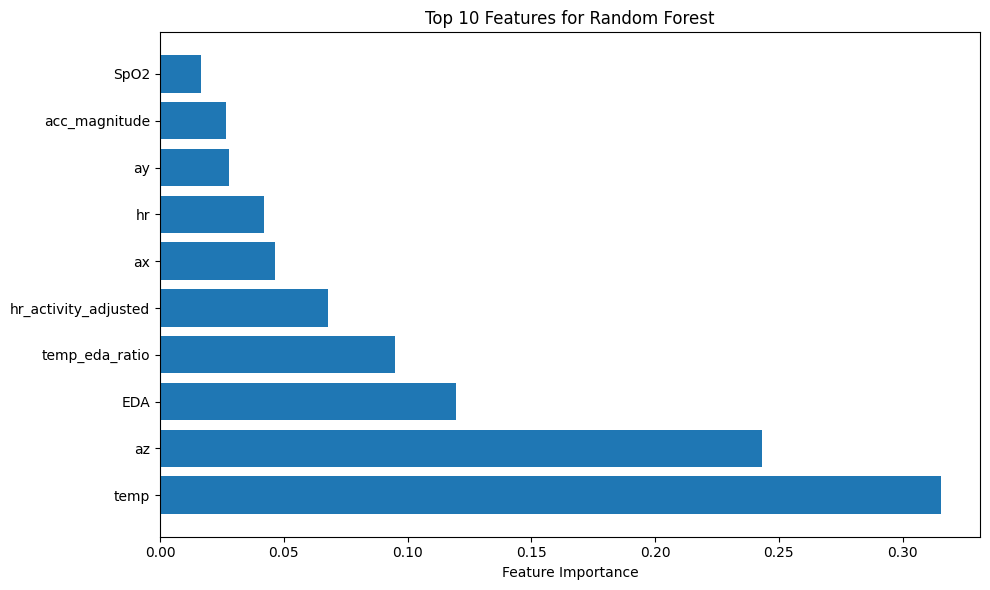

Best model (MLP Classifier)
Mean accuracy: 0.9983
Analysis completed successfully!


In [143]:
if __name__ == "__main__":
    # Load data
    X = all_subjects_df.drop(columns=['physiological_stress', 'time', 'subject_id'])
    y = all_subjects_df['physiological_stress']
    
    # Run comparative analysis code
    results = run_comparative_analysis(X, y, random_seed=42, use_smote=True, tune_hyperparams=True)
    
    # Plot feature importance
    importance_data = plot_feature_importance(results, top_n=10)
    
    # Save best model
    best_model_name, best_model = save_best_model(results)

    print(f"Best model: {best_model_name}")